# Taylor Couette

Numerical Simulations of Co-and Counter-Taylor-Couette Flows: Influence of the Cavity Radius Ratio on the Appearance of Taylor Vortices

We define the mesh :

In [1]:
from dolfin import *
import numpy as np
import mshr as mshr

mu = Constant(1.)
muv = mu.values()[0]
# Goal
Lambda = 10
eta = 0.5
Rei = 50
Reo = 0
outerR = 0.6


# Computed values
innerR = eta*outerR
gap = outerR - innerR
h = Lambda*gap
Omegai = Rei*muv/(innerR*gap)
Omegao = Reo*muv/(outerR*gap)

print(innerR)
print(Omegai)
print(Omegao)

innerCyl = mshr.Cylinder(Point([0.,0.,0.]),Point([0.,0.,h]),innerR,innerR)
outerCyl = mshr.Cylinder(Point([0.,0.,0.]),Point([0.,0.,h]),outerR,outerR)

mesh=mshr.generate_mesh(outerCyl - innerCyl,40)
#mesh = refine(mesh)
print(mesh.num_cells())

0.3
555.555555556
0.0
21858


In [2]:
# We mark physical boundary and setup the space of finite elements 
mark = {"generic": 0,
        "wall": 1,
        "inner": 2,
        "outer": 3 }
subdomains = MeshFunction("size_t", mesh,  mesh.topology().dim()-1)
subdomains.set_all(mark["generic"])
class Wall(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (near(x[2],0.) or near(x[2],h))
class Inner(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]*x[0] + x[1]*x[1] < (innerR + outerR)**2/4.) #and not (near(x[2],0.) or near(x[2],h))
class Outer(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]*x[0] + x[1]*x[1] > (innerR + outerR)**2/4.) #and not (near(x[2],0.) or near(x[2],h))
inner = Inner()
inner.mark(subdomains, mark["inner"])
outer = Outer()
outer.mark(subdomains, mark["outer"])
wall = Wall()
wall.mark(subdomains, mark["wall"])
#File("bord.pvd") << subdomains

degree = 2
elemf0 = FiniteElement('P-', cell='tetrahedron',form_degree=0, degree=degree)
elemf1 = FiniteElement('P-', cell='tetrahedron',form_degree=1, degree=degree)
elemf2 = FiniteElement('P-', cell='tetrahedron',form_degree=2, degree=degree)
elemf3 = FiniteElement('P-', cell='tetrahedron',form_degree=3, degree=degree)
elemH = FiniteElement('Real',cell='tetrahedron',degree=0)

TH = MixedElement([elemf1,elemf2,elemf3])
W = FunctionSpace(mesh, TH)

In [3]:
# We define physical parameters

nbitt = 100
#T = 8.0
#timestep = Constant(T/nbitt)
#print(timestep.values()[0])
timestep = Constant(0.001)

noslip = Constant((0.,0.,0.))
force = Constant((0.,0.,0.))

u_inner = Expression(('-omega*x[1]', 'omega*x[0]', '0.0'), degree=2, omega = Omegai)
u_outer = Expression(('-omega*x[1]', 'omega*x[0]', '0.0'), degree=2, omega = Omegao)

bcu_wall = DirichletBC(W.sub(1), noslip, subdomains, mark["wall"])
bcu_outer = DirichletBC(W.sub(1), noslip, subdomains, mark["outer"])
bcu_inner = DirichletBC(W.sub(1), noslip, subdomains, mark["inner"])

dbcs = [bcu_wall,bcu_outer,bcu_inner]

In [4]:
# Define our function for the variationnal problem and our neumanBC (required TestFunctions to be already defined)
w_old = Function(W)
(u1_o, u2_o, u3_o) = split(w_old)
(u1, u2, u3) = TrialFunctions(W)
(v1, v2, v3) = TestFunctions(W)
n = FacetNormal(mesh)

dsW = Measure('ds', domain=mesh, subdomain_id=mark["wall"], subdomain_data=subdomains)
dsouter = Measure('ds', domain=mesh, subdomain_id=mark["outer"], subdomain_data=subdomains)
dsinner = Measure('ds', domain=mesh, subdomain_id=mark["inner"], subdomain_data=subdomains)

neumanBC = dot(cross(noslip,v1),n)*dsW + dot(cross(u_outer,v1),n)*dsouter + dot(cross(u_inner,v1),n)*dsinner 

In [5]:
# Variationnal formulation (except for u_t, a and L are multiplied by timestep below)
a1 = dot(u1,v1)*dx - dot(u2,curl(v1))*dx
a2 = mu*dot(curl(u1),v2)*dx + 0.5*dot(cross(u1,u2_o),v2)*dx + 0.5*dot(cross(u1_o,u2),v2)*dx - dot(u3,div(v2))*dx
a3 = dot(div(u2),v3)*dx
a = a1 + a2 + a3
L = dot(force,v2)*dx + neumanBC

In [6]:
t = 0
w = Function(W)
print(W.dim())
for i in range(nbitt):
    print("t = {:.3f}".format(t))
    Fa = timestep*a + dot(u2,v2)*dx 
    Fl = timestep*L + dot(w_old.sub(1),v2)*dx
    problem = LinearVariationalProblem(Fa,Fl, w, dbcs)
    solver = LinearVariationalSolver(problem)
    solver.parameters['linear_solver'] = "mumps"
    
    try:
        solver.solve()
    except RuntimeError:
        print("Solver failed")
        break
    
    tmp = assemble(dot(w.sub(1) - w_old.sub(1),w.sub(1) - w_old.sub(1))*dx)
    print(tmp)
    #print(assemble(dot(w - w_old,w - w_old)*dx))
    if (tmp < 1E-6):
        print("converged")
        break
    w_old.assign(w)
    t = t + timestep.values()[0]


442283
t = 0.000
2154.654851353612
t = 0.001
306.0804253198925
t = 0.002
122.2009175480306
t = 0.003
69.23891551688412
t = 0.004
45.60701595661691
t = 0.005
32.55445725087334
t = 0.006
24.344390238159
t = 0.007
18.722791577193227
t = 0.008
14.649900134381381
t = 0.009
11.586116334900217
t = 0.010
9.224035525873944
t = 0.011
7.374035139712195
t = 0.012
5.910652242689209
t = 0.013
4.745855248010979
t = 0.014
3.815051799480223
t = 0.015
3.0693380369518577
t = 0.016
2.470901022290201
t = 0.017
1.9900984202776855
t = 0.018
1.6034866944084671
t = 0.019
1.2924195700243846
t = 0.020
1.042011970376223
t = 0.021
0.8403526391129175
t = 0.022
0.6778943902071283
t = 0.023
0.546976013335312
t = 0.024
0.4414444159544639
t = 0.025
0.3563544493087186
t = 0.026
0.28772962494963106
t = 0.027
0.23237092137205906
t = 0.028
0.18770376597518765
t = 0.029
0.15165542239549895
t = 0.030
0.12255664935510169
t = 0.031
0.09906276738042392
t = 0.032
0.0800902643819112
t = 0.033
0.06476585455214699
t = 0.034
0.05238

In [7]:
(cu,u,p) = w.split(True)
# Stream function
WS = FunctionSpace(mesh, MixedElement([elemf0,elemf1,elemf2,elemf3,elemH,elemH]))
u_happ = Expression(('-x[1]/(x[1]*x[1] + x[0]*x[0])', 'x[0]/(x[1]*x[1] + x[0]*x[0])', '0.0'), degree=2)
print(WS.dim())
(uS0,uS1,uS2,uS3,uSp2,uSp3) = TrialFunctions(WS)
(vS0,vS1,vS2,vS3,vSq2,vSq3) = TestFunctions(WS)
aS = dot(grad(uS0),vS1)*dx + dot(curl(uS1),vS2)*dx + div(uS2)*vS3*dx + \
    dot(grad(vS0),uS1)*dx + dot(curl(vS1),uS2)*dx + div(vS2)*uS3*dx + \
    uSp2*dot(u_happ,vS2)*dx + vSq2*dot(u_happ,uS2)*dx + uSp3*vS3*dx + vSq3*uS3*dx
LS = dot(u,vS2)*dx
class Boundary_w(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary
dbcsS = [DirichletBC(WS.sub(0), Constant(0.), Boundary_w()),
        DirichletBC(WS.sub(1), noslip, Boundary_w()),
        DirichletBC(WS.sub(2), noslip, Boundary_w())]
wS = Function(WS)
problemS = LinearVariationalProblem(aS,LS, wS, dbcsS)
solverS = LinearVariationalSolver(problemS)
solverS.parameters['linear_solver'] = "mumps"
solverS.solve()
PSI = wS.split(True)[1]

476106


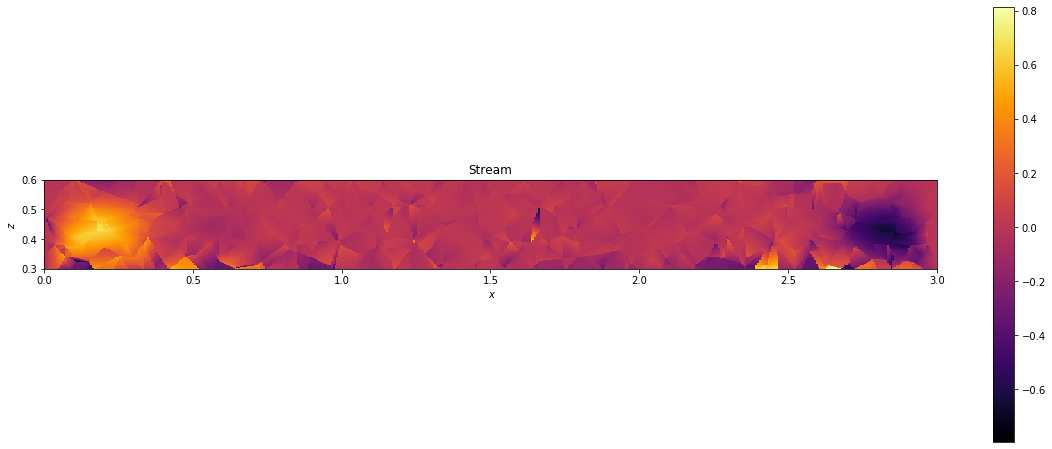

In [8]:
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
PSI.set_allow_extrapolation(True)
x = np.linspace(innerR , outerR , 101)
z = np.linspace(0 , h , 501)
f = [[PSI(x_, 0., z_)[1] for z_ in z] for x_ in x]
# f = gaussian_filter(f, 5) # can helps the reading
plt.figure(figsize=(20, 8))
plt.imshow(f,origin="lower",
           extent=[0,h,innerR, outerR],cmap='inferno') 
plt.colorbar()
plt.title(r"Stream")
plt.xlabel(r" $x$ ")
plt.ylabel(r"$z$ ")
plt.show()